## Percobaan Augmentasi Data

In [2]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

| Library                                       | Fungsi / Kegunaan                                                                                              |
|----------------------------------------------|---------------------------------------------------------------------------------------------------------------|
| `os`                                          | Untuk berinteraksi dengan sistem file (misalnya membaca nama file, direktori, dll).                           |
| `cv2 (OpenCV)`                                | Digunakan untuk pemrosesan citra seperti membaca gambar, mengubah warna, filtering, hingga deteksi tepi.     |
| `matplotlib.pyplot`                           | Untuk membuat grafik atau visualisasi hasil pengolahan data dan citra.                                        |
| `numpy`                                       | Library numerik untuk perhitungan array, operasi linear, transformasi, dan fungsi matematis lainnya.          |
| `pandas`                                      | Digunakan untuk memuat, memproses, dan menganalisis data dalam format tabel (DataFrame).                      |
| `sklearn.model_selection.train_test_split`    | Membagi dataset menjadi data latih dan data uji agar model bisa diuji performanya.                            |
| `sklearn.model_selection.cross_val_predict`   | Melakukan prediksi dengan teknik validasi silang untuk mendapatkan hasil yang lebih stabil.                   |
| `sklearn.metrics.accuracy_score`             | Mengukur persentase prediksi yang benar dibandingkan total data.                                               |
| `sklearn.metrics.precision_score`            | Mengukur seberapa akurat model dalam memprediksi kelas positif.                                               |
| `sklearn.metrics.recall_score`               | Mengukur seberapa baik model dalam menemukan semua data yang termasuk kelas positif.                         |
| `sklearn.metrics.f1_score`                   | Kombinasi harmonis dari precision dan recall untuk evaluasi performa menyeluruh.                              |
| `sklearn.metrics.confusion_matrix`           | Menampilkan jumlah prediksi benar dan salah dalam bentuk matriks.                                             |
| `sklearn.metrics.classification_report`      | Ringkasan metrik klasifikasi seperti precision, recall, dan F1-score untuk setiap kelas.                      |
| `sklearn.metrics.ConfusionMatrixDisplay`     | Menampilkan visualisasi matriks kebingungan dalam bentuk grafik.                                              |
| `skimage.feature.graycomatrix`               | Menghitung *Gray-Level Co-Occurrence Matrix (GLCM)* dari citra grayscale sebagai representasi tekstur.        |
| `skimage.feature.graycoprops`                | Mengambil nilai-nilai statistik (seperti kontras, korelasi) dari GLCM yang telah dihitung.                    |
| `scipy.stats.entropy`                        | Mengukur ketidakteraturan atau kompleksitas distribusi data dengan rumus entropi.                             |
| `sklearn.ensemble.RandomForestClassifier`    | Model klasifikasi berbasis banyak pohon keputusan (ensemble learning) yang kuat dan stabil.                   |
| `sklearn.svm.SVC`                            | Model klasifikasi menggunakan Support Vector Machine untuk memisahkan kelas dengan margin optimal.            |
| `sklearn.neighbors.KNeighborsClassifier`     | Mengklasifikasikan data berdasarkan mayoritas tetangga terdekatnya dalam ruang fitur.                         |
| `seaborn`                                     | Library visualisasi yang membuat grafik statistik lebih menarik dan mudah dibaca, terutama untuk analisis data.|


## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [4]:
resize_to = (28, 28)

data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset"):
    sub_folder_path = os.path.join("dataset", sub_folder)
    sub_folder_files = os.listdir(sub_folder_path)

    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)

        if img is None:
            print(f"Gagal membaca: {img_path}")
            continue

        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, resize_to) 

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

data = np.array(data)
labels = np.array(labels)


kode tersebut digunakan untuk membaca dan memproses kumpulan citra dari struktur folder yang tersusun berdasarkan label. Pertama, ditentukan ukuran citra hasil resize, yaitu 28x28 piksel. Kemudian, kode menginisialisasi tiga list kosong: `data` untuk menyimpan citra, `labels` untuk label citra, dan `file_name` untuk menyimpan nama file. Selanjutnya, kode menelusuri setiap subfolder dalam direktori `dataset\`, yang diasumsikan mewakili kelas atau label. Untuk setiap file gambar dalam subfolder, citra dibaca menggunakan OpenCV (`cv.imread`). Jika citra gagal dibaca, akan dicetak pesan kesalahan dan gambar dilewati. Jika berhasil, citra dikonversi menjadi format `uint8`, diubah ke grayscale, dan diubah ukurannya menjadi 28x28 piksel. Citra yang sudah diproses ditambahkan ke dalam `data`, nama subfolder ke dalam `labels` (sebagai labelnya), dan nama file ke dalam `file_name`. Setelah semua gambar diproses, list `data` dan `labels` dikonversi ke dalam array NumPy agar lebih efisien untuk pemrosesan selanjutnya.


## Data Augmentation

### Define Augmentation Function


In [5]:
def rotasi(image, sudut):
    height, width = image.shape[0], image.shape[1]
    pusat_rotasi = np.array([width // 2, height // 2])
    rad_rotasi = np.radians(sudut)
    cosine = np.cos(rad_rotasi)
    sine = np.sin(rad_rotasi)

    citra_rotasi = np.zeros_like(image)

    for x in range(height):
        for y in range(width):
            xp = int((x-pusat_rotasi[1]) * cosine - (y - pusat_rotasi[0]) * sine + pusat_rotasi[1])
            yp = int((x - pusat_rotasi[0]) * sine + (y - pusat_rotasi[0]) * cosine + pusat_rotasi[0])
            if 0 <= xp < height and 0 <= yp < width:
                citra_rotasi[x,y] = image[xp, yp]   
    return citra_rotasi

Fungsi `rotasi` digunakan untuk memutar sebuah citra sebesar `sudut` derajat terhadap pusat citra. Pertama, fungsi ini menentukan tinggi dan lebar citra, lalu menghitung pusat rotasi sebagai titik tengah dari dimensi citra. Selanjutnya, sudut rotasi dikonversi ke bentuk radian dan nilai kosinus serta sinus dari sudut tersebut dihitung untuk digunakan dalam transformasi rotasi.

Kemudian, fungsi membuat sebuah array kosong `citra_rotasi` dengan ukuran yang sama seperti citra input. Proses rotasi dilakukan dengan iterasi dua tingkat terhadap setiap piksel `(x, y)` dalam citra. Untuk setiap piksel, dihitung posisi baru `(xp, yp)` berdasarkan rumus transformasi rotasi 2D. Jika hasil koordinat baru masih berada dalam batas citra (tidak keluar dari ukuran asli), maka nilai piksel dari posisi baru tersebut digunakan untuk mengisi nilai pada posisi asalnya di `citra_rotasi`.

Akhirnya, fungsi mengembalikan `citra_rotasi` sebagai hasil citra yang sudah diputar.


In [6]:
# melakukan augmentasi data
data_augmented = list(data) 
labels_augmented = list(labels) 
file_name_augmented = list(file_name) 

for i in range(len(data)):
    img = data[i]
    label = labels[i]
    original_filename = file_name[i]

    rows, cols = img.shape
    center_x, center_y = cols / 2, rows / 2 # Pusat rotasi


    angles = [-30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30] 
    for angle_deg in angles:
        rotated_img = rotasi(img, angle_deg)
        
        data_augmented.append(rotated_img)
        labels_augmented.append(label)
        file_name_augmented.append(f"{original_filename}_rot{angle_deg}.jpg")

    flipped_h = img[::-1, :]
    data_augmented.append(flipped_h)
    labels_augmented.append(label)
    file_name_augmented.append(f"{original_filename}_flipH.jpg")

    flipped_v = img[:, ::-1]
    data_augmented.append(flipped_v)
    labels_augmented.append(label)
    file_name_augmented.append(f"{original_filename}_flipV.jpg")

data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)
file_name_augmented = np.array(file_name_augmented)

Kode di atas melakukan augmentasi data citra untuk memperbesar jumlah data pelatihan dengan variasi yang beragam. Pertama, data asli yang terdapat dalam list `data`, `labels`, dan `file_name` disalin ke dalam list baru bernama `data_augmented`, `labels_augmented`, dan `file_name_augmented`. Ini bertujuan agar data hasil augmentasi tetap mempertahankan data asli.

Selanjutnya, untuk setiap citra dalam dataset, dilakukan rotasi pada beberapa sudut tertentu yang telah didefinisikan dalam list `angles` (dari -30 hingga 30 derajat, kecuali 0). Proses rotasi menggunakan fungsi `rotasi` yang memutar citra terhadap pusatnya. Setiap hasil rotasi kemudian ditambahkan ke dalam list augmented bersama dengan label aslinya dan nama file yang telah ditandai dengan sudut rotasi.

Setelah proses rotasi, dilakukan juga dua bentuk flipping (pencerminan), yaitu flipping horizontal (cermin terhadap sumbu horizontal) dan flipping vertikal (cermin terhadap sumbu vertikal). Kedua hasil flipping tersebut juga dimasukkan ke dalam list augmented bersama label dan nama file yang telah dimodifikasi untuk menunjukkan tipe augmentasinya.

Pada akhir proses, ketiga list hasil augmentasi (citra, label, dan nama file) dikonversi ke dalam array NumPy agar dapat digunakan dalam tahap pemrosesan atau pelatihan model berikutnya.


In [7]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  329
Data setelah augmentasi:  4935


Kode di atas digunakan untuk menampilkan jumlah data sebelum dan sesudah proses augmentasi. `print("Data sebelum augmentasi: ", len(data))` mencetak jumlah citra asli yang terdapat dalam list `data`, sementara `print("Data setelah augmentasi: ", len(data_augmented))` mencetak jumlah total citra setelah dilakukan augmentasi, yang mencakup data asli serta hasil rotasi dan flipping. Perbandingan antara dua angka ini memberikan gambaran seberapa banyak data telah ditambahkan melalui proses augmentasi.

## Data Preparation

### Define Preprocessing Function


In [8]:
def equalize(image):
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    height, width = image.shape
    total_pixels = height * width
    
    histogram = [0] * 256
    for i in range(height):
        for j in range(width):
            intensity = image[i, j]
            histogram[intensity] += 1

    cdf = [0] * 256
    cdf[0] = histogram[0]
    for i in range(1, 256):
        cdf[i] = cdf[i-1] + histogram[i]

    cdf_min = min([x for x in cdf if x > 0])

    denominator = (total_pixels - cdf_min)
    if denominator == 0:
        cdf_normalized = [0] * 256 
    else:
        cdf_normalized = [(cdf[i] - cdf_min) * 255 // denominator for i in range(256)]

    equalized_image = np.zeros_like(image, dtype=np.uint8) 
    for i in range(height):
        for j in range(width):
            old_value = image[i, j]
            new_value = cdf_normalized[old_value]
            equalized_image[i, j] = new_value

    return equalized_image

def threshold(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] >= 85:
                image[i][j] = 255
            else: 
                image[i][j] = 0
    return image

Fungsi `equalize(image)` digunakan untuk meningkatkan kontras citra dengan metode histogram equalization. Jika citra yang diberikan berupa citra berwarna (memiliki tiga channel), maka citra tersebut terlebih dahulu dikonversi menjadi citra grayscale menggunakan `cv2.cvtColor`. Selanjutnya, fungsi menghitung histogram distribusi intensitas piksel dalam citra dan membentuk fungsi distribusi kumulatif (CDF). CDF ini kemudian dinormalisasi agar mencakup rentang intensitas 0 hingga 255. Nilai-nilai CDF yang telah dinormalisasi digunakan untuk membentuk citra baru yang telah melalui proses equalization, sehingga persebaran intensitasnya menjadi lebih merata dan citra tampak lebih kontras.

Fungsi `threshold(image)` digunakan untuk mengubah citra grayscale menjadi citra biner (hitam-putih) berdasarkan ambang batas tertentu, yaitu 85. Proses ini dilakukan dengan memeriksa nilai intensitas tiap piksel: jika nilai piksel lebih besar atau sama dengan 85, maka piksel tersebut diubah menjadi 255 (putih); jika lebih kecil dari 85, maka piksel diubah menjadi 0 (hitam). Hasilnya adalah citra biner yang menyoroti objek atau area tertentu berdasarkan perbedaan intensitas.


### Preprocessing

In [9]:
dataPreprocessed = []
for i in range(len(data)):
    img = equalize(data[i])  
    img = threshold(img)
    dataPreprocessed.append(img)

Kode tersebut melakukan prapemrosesan pada data citra dalam daftar `data`. Setiap citra diproses secara berurutan melalui dua tahap utama. Pertama, dilakukan **equalisasi histogram** menggunakan fungsi `equalize()` untuk meningkatkan kontras citra, sehingga distribusi intensitas piksel menjadi lebih merata. Kedua, hasil dari equalisasi tersebut kemudian diterapkan **thresholding** menggunakan fungsi `threshold()` dengan ambang batas 85 untuk mengubah citra grayscale menjadi citra biner (hitam-putih), yang berguna untuk menekankan perbedaan antara objek dan latar belakang. Citra yang telah diproses kemudian disimpan ke dalam daftar baru bernama `dataPreprocessed`.


Kode tersebut menampilkan citra hasil prapemrosesan dalam bentuk grid berdasarkan label masing-masing. Pertama, kode mengidentifikasi semua label unik dari daftar `labels` dan mengurutkannya. Kemudian, untuk setiap label, kode mencari indeks-indeks citra yang memiliki label tersebut. Selanjutnya, kode membuat tampilan grid berukuran 2 baris dan 5 kolom (untuk menampilkan 10 gambar) menggunakan `matplotlib`. Judul untuk setiap grid diberikan sesuai label yang sedang ditampilkan, dan setiap citra diakses dari `dataPreprocessed` berdasarkan indeks yang ditemukan, kemudian ditampilkan dalam skala abu-abu tanpa sumbu koordinat. Tata letak gambar dirapikan dengan `plt.tight_layout()` agar tampilan lebih teratur dan tidak saling bertumpukan.

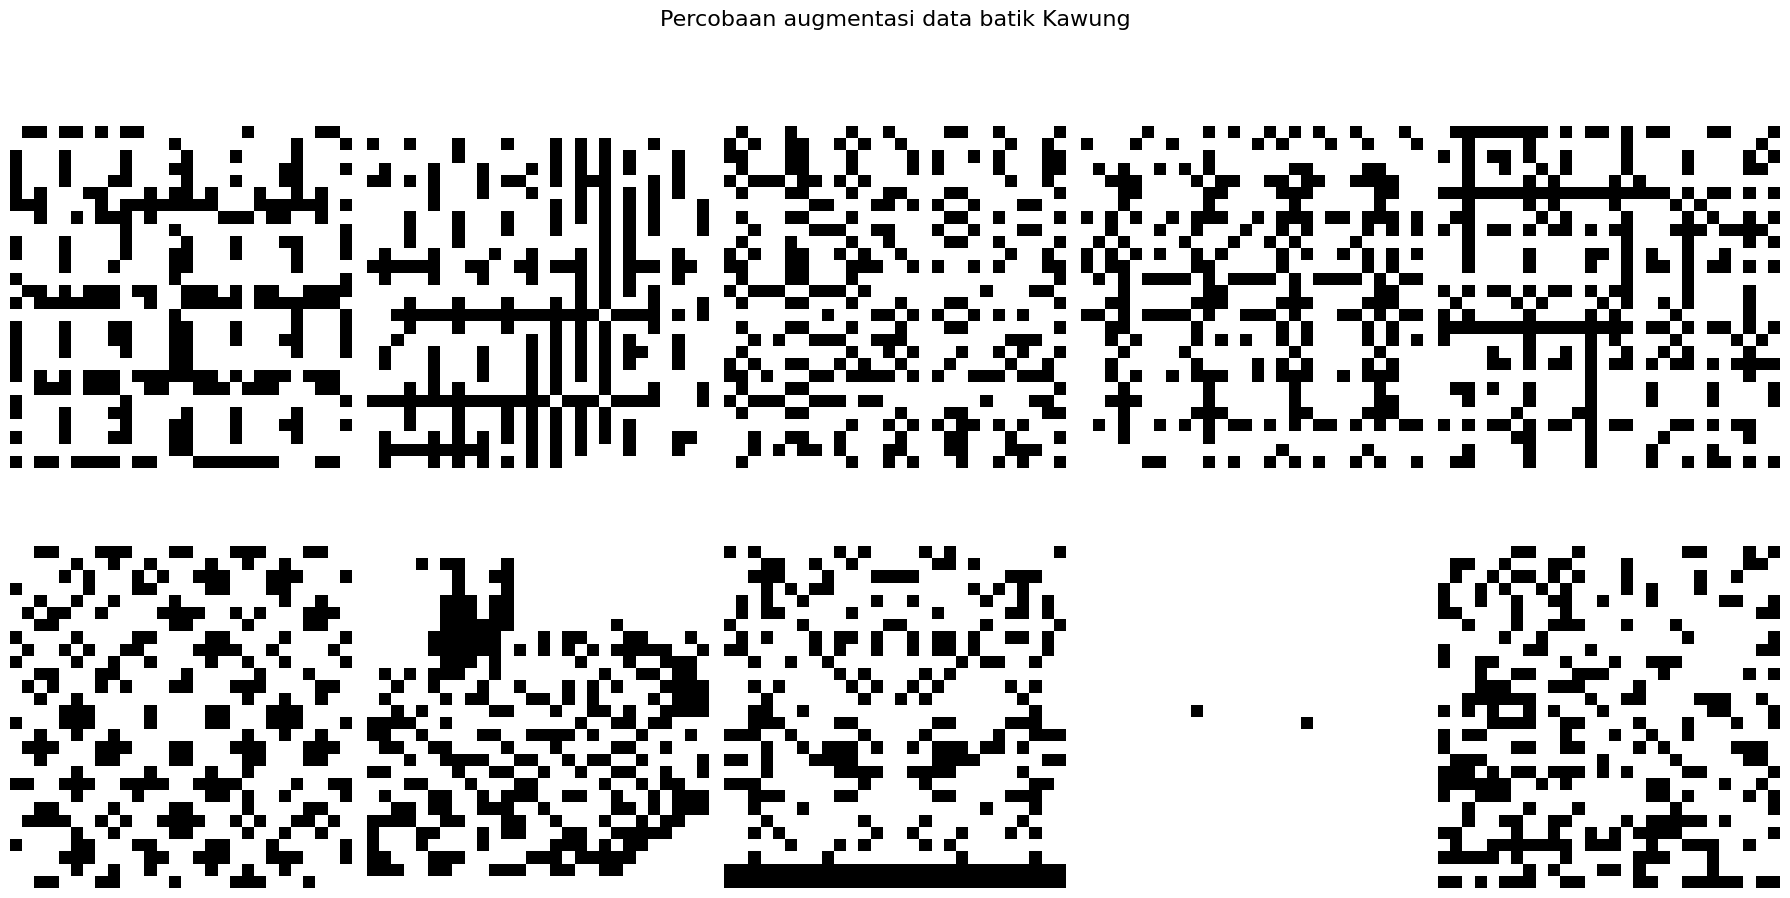

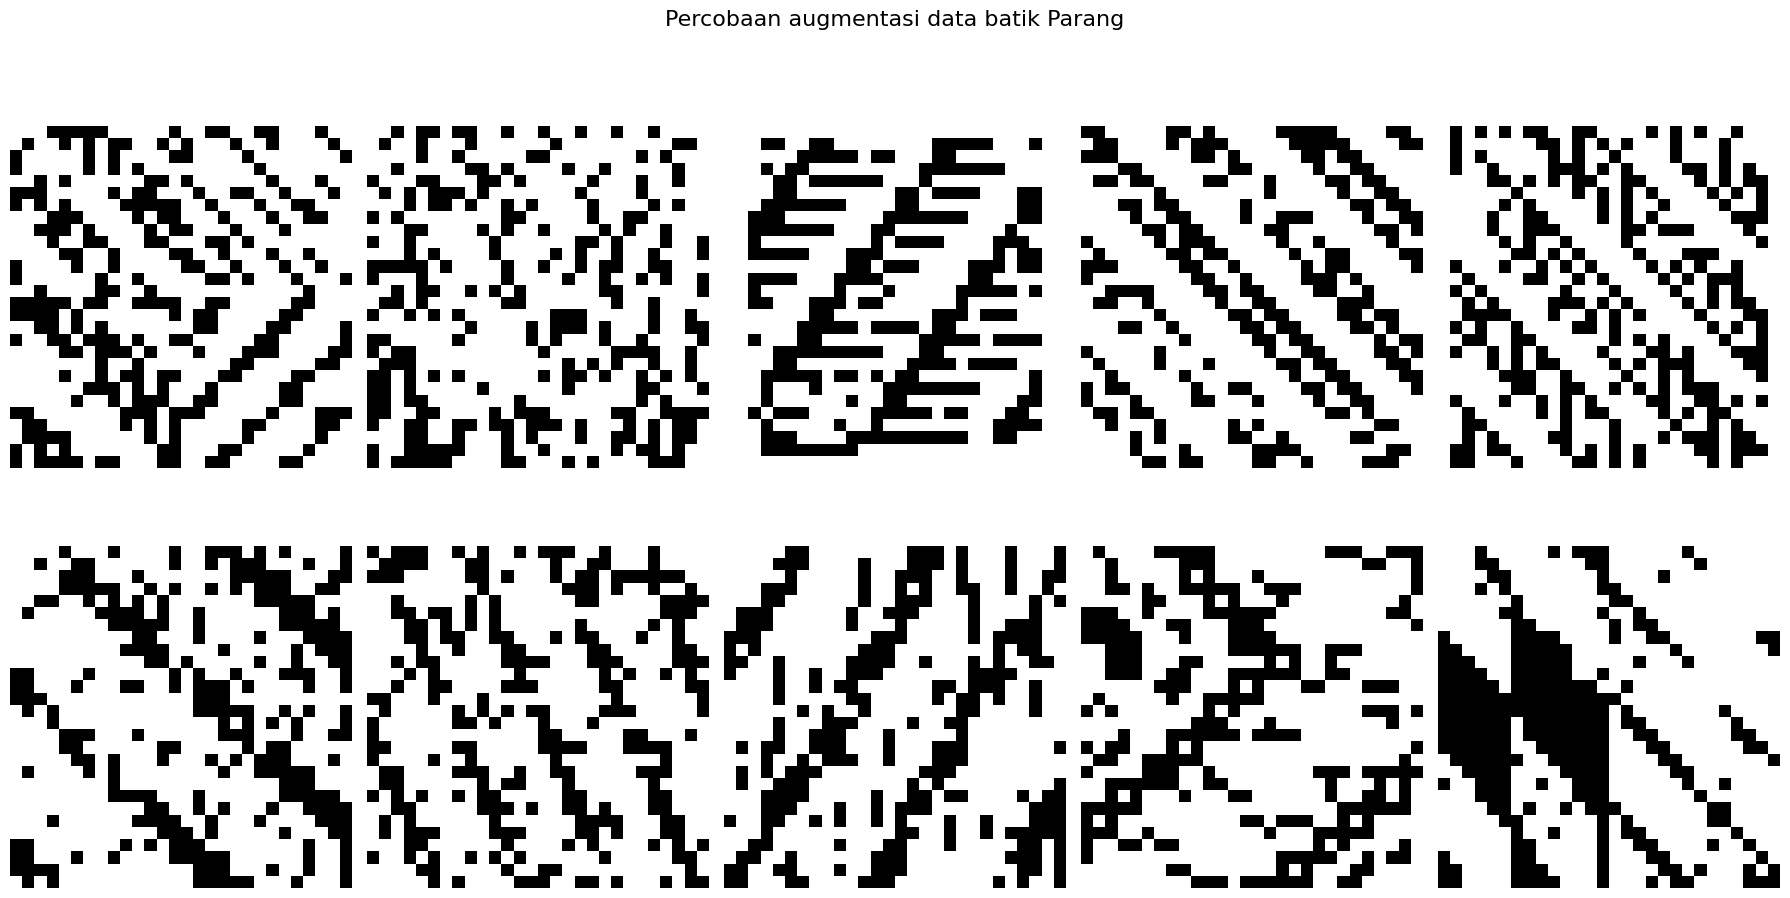

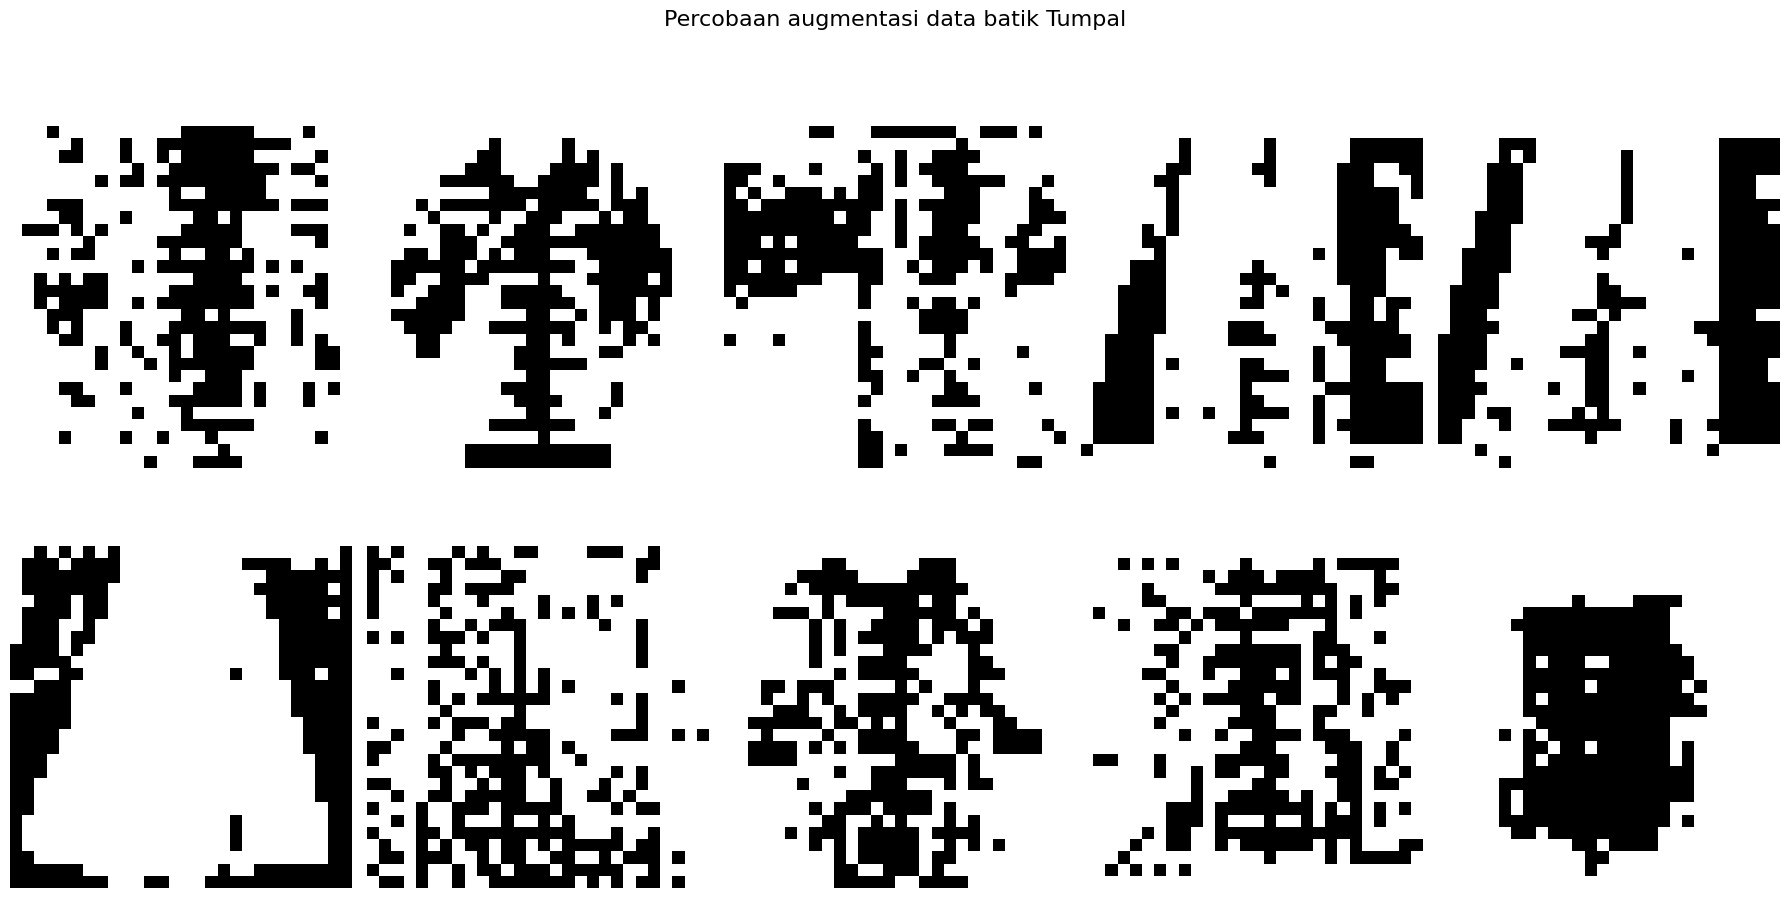

In [12]:
unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(2, 5, figsize=(18, 10))
    fig.suptitle(f'Percobaan augmentasi data batik {label}', fontsize=16)
    
    for k in range(10):
        row = k // 5
        col = k % 5
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()

### Feature Extraction

In [13]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Fungsi `glcm` digunakan untuk menghitung matriks **Gray Level Co-occurrence Matrix (GLCM)** dari sebuah citra tingkat keabuan. Fungsi ini menerima dua parameter, yaitu `image` (citra input) dan `derajat` (arah pergeseran piksel dalam derajat: 0, 45, 90, atau 135). Berdasarkan nilai `derajat`, fungsi akan mengonversinya ke dalam radian untuk menentukan arah sudut yang sesuai. Kemudian, fungsi memanggil `graycomatrix` dari pustaka `skimage.feature` untuk menghitung GLCM dengan jarak piksel 1, tingkat keabuan 256, serta opsi `symmetric=True` agar matriks simetris dan `normed=True` agar hasilnya ternormalisasi. Matriks GLCM yang dihasilkan kemudian dikembalikan sebagai output fungsi.

In [14]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi correlation(matriks) mengambil sebuah matriks GLCM sebagai input dan mengembalikan nilai korelasi tekstur yang dihitung menggunakan fungsi graycoprops dari skimage.feature. Korelasi ini mengukur sejauh mana nilai pixel dalam gambar saling terkait secara linear pada pola tekstur tertentu. Fungsi mengakses elemen [0, 0] dari hasil graycoprops karena GLCM yang dihasilkan biasanya dalam bentuk 4D, dan di sini fokus hanya pada nilai korelasi pertama. Nilai korelasi ini berguna untuk menganalisis hubungan spasial antar pixel dalam gambar.

In [15]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi dissimilarity(matriks) menerima matriks GLCM sebagai input dan mengembalikan nilai dissimilarity tekstur menggunakan fungsi graycoprops dari skimage.feature. Nilai dissimilarity mengukur seberapa berbeda intensitas pixel yang berdekatan dalam gambar, memberikan informasi tentang variasi tekstur. Sama seperti fungsi korelasi, hasilnya diakses pada indeks [0, 0] karena GLCM biasanya berformat 4D. Nilai ini berguna untuk memahami tingkat ketidaksamaan lokal dalam pola tekstur gambar.

In [16]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi homogenity(matriks) menerima matriks GLCM dan mengembalikan nilai homogeneity (keseragaman) tekstur yang dihitung menggunakan graycoprops dari skimage.feature. Nilai ini mengukur seberapa seragam atau konsisten tekstur dalam gambar, dengan nilai tinggi menunjukkan tekstur yang lebih halus dan seragam. Sama seperti sebelumnya, hasilnya diambil pada indeks [0, 0] karena format matriks GLCM. Fitur homogenity ini penting untuk analisis pola tekstur dalam citra.

In [17]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi contrast(matriks) menerima matriks GLCM sebagai input dan mengembalikan nilai contrast tekstur yang dihitung dengan graycoprops dari skimage.feature. Nilai contrast mengukur tingkat variasi intensitas antar pixel dalam gambar, di mana nilai tinggi menunjukkan perbedaan intensitas yang lebih tajam atau tekstur yang lebih kasar. Hasil diambil dari indeks [0, 0] sesuai format matriks GLCM. Fitur ini berguna untuk menilai tingkat ketajaman atau perubahan pola pada gambar.

In [18]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi ASM(matriks) menerima matriks GLCM dan mengembalikan nilai Angular Second Moment (ASM) atau energy tekstur menggunakan graycoprops dari skimage.feature. Nilai ASM mengukur konsentrasi atau keteraturan pola tekstur dalam gambar; nilai tinggi menunjukkan tekstur yang lebih seragam dan teratur. Seperti fungsi lain, hasilnya diambil dari indeks [0, 0] karena format matriks GLCM. ASM sering digunakan untuk menilai homogenitas dan kekuatan pola tekstur.

In [19]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi energy(matriks) menerima matriks GLCM sebagai input dan mengembalikan nilai energy tekstur yang dihitung dengan graycoprops dari skimage.feature. Energy merupakan akar kuadrat dari Angular Second Moment (ASM) dan mengukur kekuatan atau intensitas pola tekstur dalam gambar, dengan nilai tinggi menunjukkan tekstur yang lebih konsisten dan teratur. Hasil diambil dari indeks [0, 0] sesuai format matriks GLCM. Fitur energy ini penting untuk analisis kekuatan pola dalam citra.


In [20]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Fungsi entropyGlcm(matriks) menghitung entropi dari matriks GLCM yang diberikan dengan terlebih dahulu meratakan matriks tersebut menjadi satu dimensi menggunakan .ravel(), lalu menerapkan fungsi entropy dari modul scipy.stats atau sejenisnya. Entropi mengukur tingkat ketidakpastian atau kompleksitas tekstur dalam gambar; nilai entropi yang tinggi menunjukkan pola tekstur yang lebih acak atau kompleks. Fungsi ini berguna untuk menilai keragaman dan keacakan fitur tekstur pada citra.

In [21]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode ini menghitung matriks GLCM untuk setiap gambar hasil sharpening (img_sharpened) pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Dalam setiap iterasi, fungsi glcm dipanggil dengan gambar ke-i dan sudut yang berbeda, lalu hasil matriks GLCM tersebut disimpan secara terpisah dalam list Derajat0, Derajat45, Derajat90, dan Derajat135. Dengan begitu, setiap gambar memiliki empat matriks GLCM yang mewakili tekstur dari berbagai arah, yang bisa digunakan untuk ekstraksi fitur tekstur lebih lanjut.

In [22]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Kode ini mendefinisikan 24 list kosong yang akan digunakan untuk menyimpan nilai fitur tekstur hasil ekstraksi dari matriks GLCM di empat arah sudut berbeda (0°, 45°, 90°, dan 135°). Setiap fitur — seperti contrast, dissimilarity, homogeneity, entropy, ASM, energy, dan correlation — memiliki empat list terpisah sesuai sudutnya, misalnya Kontras0 untuk sudut 0°, Kontras45 untuk sudut 45°, dan seterusnya. List-list ini nantinya akan diisi dengan nilai fitur tekstur dari tiap gambar sebagai bagian dari proses ekstraksi fitur tekstur citra.

In [23]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode ini melakukan perulangan untuk setiap gambar hasil sharpening (img_sharpened) dan menghitung fitur korelasi tekstur dari matriks GLCM yang sudah disimpan sebelumnya pada masing-masing sudut (0°, 45°, 90°, dan 135°) menggunakan fungsi correlation(). Nilai korelasi yang dihitung untuk tiap sudut kemudian disimpan ke dalam list yang sesuai: correlation0, correlation45, correlation90, dan correlation135. Dengan cara ini, fitur korelasi tekstur dari semua gambar di semua arah tersimpan terpisah untuk analisis atau pemrosesan lebih lanjut.

In [24]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode ini melakukan perulangan untuk setiap gambar hasil sharpening (img_sharpened) dan menghitung fitur korelasi tekstur dari matriks GLCM yang sudah disimpan sebelumnya pada masing-masing sudut (0°, 45°, 90°, dan 135°) menggunakan fungsi correlation(). Nilai korelasi yang dihitung untuk tiap sudut kemudian disimpan ke dalam list yang sesuai: correlation0, correlation45, correlation90, dan correlation135. Dengan cara ini, fitur korelasi tekstur dari semua gambar di semua arah tersimpan terpisah untuk analisis atau pemrosesan lebih lanjut.

In [25]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode ini melakukan perulangan untuk setiap gambar hasil sharpening dan menghitung fitur dissimilarity dari matriks GLCM yang sudah dihitung pada empat sudut (0°, 45°, 90°, 135°) menggunakan fungsi dissimilarity(). Nilai yang diperoleh untuk tiap sudut disimpan ke dalam list yang sesuai (dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135). Dengan cara ini, fitur dissimilarity tekstur untuk semua gambar dan arah tersimpan untuk analisis lebih lanjut.

In [26]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode ini menghitung fitur homogeneity (keseragaman tekstur) untuk setiap gambar hasil sharpening dengan memanfaatkan matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, 135°) menggunakan fungsi homogenity(). Nilai homogeneity yang dihasilkan untuk tiap sudut disimpan masing-masing ke dalam list homogenity0, homogenity45, homogenity90, dan homogenity135. Ini memungkinkan analisis keseragaman tekstur gambar dari berbagai arah secara terpisah.

In [27]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode ini menghitung nilai entropi tekstur dari setiap gambar hasil sharpening berdasarkan matriks GLCM pada empat sudut (0°, 45°, 90°, dan 135°) menggunakan fungsi entropyGlcm(). Nilai entropi yang diperoleh untuk tiap sudut kemudian disimpan ke dalam list entropy0, entropy45, entropy90, dan entropy135. Entropi ini mengukur kompleksitas atau kerandoman tekstur dari gambar di berbagai arah, yang penting untuk analisis pola tekstur.

In [28]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode ini melakukan iterasi untuk setiap gambar hasil sharpening dan menghitung fitur Angular Second Moment (ASM) dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) menggunakan fungsi ASM(). Nilai ASM yang diperoleh untuk masing-masing sudut disimpan ke dalam list ASM0, ASM45, ASM90, dan ASM135. ASM ini mengukur keteraturan dan homogenitas pola tekstur dalam gambar, sehingga penting untuk analisis tekstur yang mendalam.

In [29]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode ini melakukan perulangan pada setiap gambar hasil sharpening dan menghitung fitur energy tekstur dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) dengan menggunakan fungsi energy(). Nilai energy yang diperoleh kemudian disimpan secara terpisah dalam list energy0, energy45, energy90, dan energy135. Fitur energy ini menggambarkan kekuatan dan konsistensi pola tekstur pada citra di berbagai arah.

### Write the extraction's results to CSV 

In [30]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,tumpal.11.jpg,Tumpal,18234.523810,22566.975309,18836.607143,22566.975309,0.719581,0.652955,0.710322,0.652955,...,0.350231,0.321448,0.590427,0.566964,0.591803,0.566964,0.376296,0.232096,0.347566,0.232096
1,tumpal.39.jpg,Tumpal,13761.904762,19266.666667,15310.119048,17125.925926,0.788363,0.703708,0.764554,0.736630,...,0.372071,0.350295,0.616635,0.579481,0.609976,0.591857,0.532713,0.349795,0.474344,0.422040
2,tumpal.6.jpg,Tumpal,16256.250000,19266.666667,16428.273810,18374.691358,0.750004,0.703708,0.747358,0.717425,...,0.368966,0.354672,0.608508,0.590673,0.607426,0.595543,0.434668,0.330556,0.428686,0.361549
3,tumpal.7.jpg,Tumpal,14536.011905,17839.506173,10751.488095,18017.901235,0.776458,0.725656,0.834659,0.722912,...,0.411133,0.346475,0.616279,0.589666,0.641197,0.588621,0.499482,0.394659,0.633271,0.388606
4,tumpal.38.jpg,Tumpal,12901.785714,16144.753086,9547.321429,14182.407407,0.801590,0.751718,0.853177,0.781896,...,0.423045,0.381865,0.633251,0.604782,0.650419,0.617952,0.549009,0.445295,0.674940,0.512718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,kawung.41.jpg,Kawung,30878.273810,20247.839506,30964.285714,20069.444444,0.525140,0.688619,0.523817,0.691363,...,0.308799,0.341717,0.555350,0.583673,0.555697,0.584566,-0.073832,0.300101,-0.077921,0.306268
325,kawung.54.jpg,Kawung,26491.666667,32467.901235,27179.761905,32824.691358,0.592599,0.500694,0.582017,0.495207,...,0.309667,0.305579,0.564469,0.552771,0.556478,0.552792,0.073964,-0.123457,0.065023,-0.135802
326,kawung.68.jpg,Kawung,23653.273810,29078.395062,24341.369048,29613.580247,0.636249,0.552819,0.625667,0.544589,...,0.318303,0.302192,0.565880,0.550448,0.564183,0.549720,0.188662,0.005798,0.163467,-0.012500
327,kawung.83.jpg,Kawung,7999.107143,8027.777778,4386.607143,8830.555556,0.876986,0.876545,0.932541,0.864200,...,0.501339,0.457459,0.682044,0.682696,0.708053,0.676357,0.711861,0.709998,0.845186,0.680601


Kode ini membuat sebuah dictionary dataTable yang berisi semua fitur tekstur hasil ekstraksi dari gambar, termasuk nama file (diberi label Image_1, Image_2, dst), kelas label, dan semua fitur GLCM pada keempat sudut (0°, 45°, 90°, 135°) seperti contrast, homogeneity, dissimilarity, entropy, ASM, energy, dan correlation. Dictionary ini kemudian diubah menjadi DataFrame pandas dan disimpan ke file CSV bernama hasil_ekstraksi_pros1.csv. Selanjutnya, file CSV tersebut dibaca kembali ke variabel hasilEkstrak, kolom Filename dihapus karena tidak diperlukan untuk analisis, lalu data fitur disimpan ke x dan label kelas ke y untuk persiapan pemodelan atau analisis lebih lanjut.

### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

Kode ini menghitung matriks korelasi antar fitur pada dataset x menggunakan x.corr(). Hasil korelasi tersebut divisualisasikan dengan heatmap menggunakan seaborn (sns.heatmap), yang menampilkan nilai korelasi antar fitur dalam format dua desimal, menggunakan skema warna coolwarm untuk memperjelas hubungan positif dan negatif antar fitur. Heatmap dibuat dalam ukuran besar (20x16 inci), diberi judul "Correlation Matrix", kemudian disimpan sebagai file gambar correlation_matrix1.png, dan terakhir ditampilkan di layar. Visualisasi ini membantu memahami sejauh mana fitur-fitur saling berkaitan satu sama lain.

<Axes: >

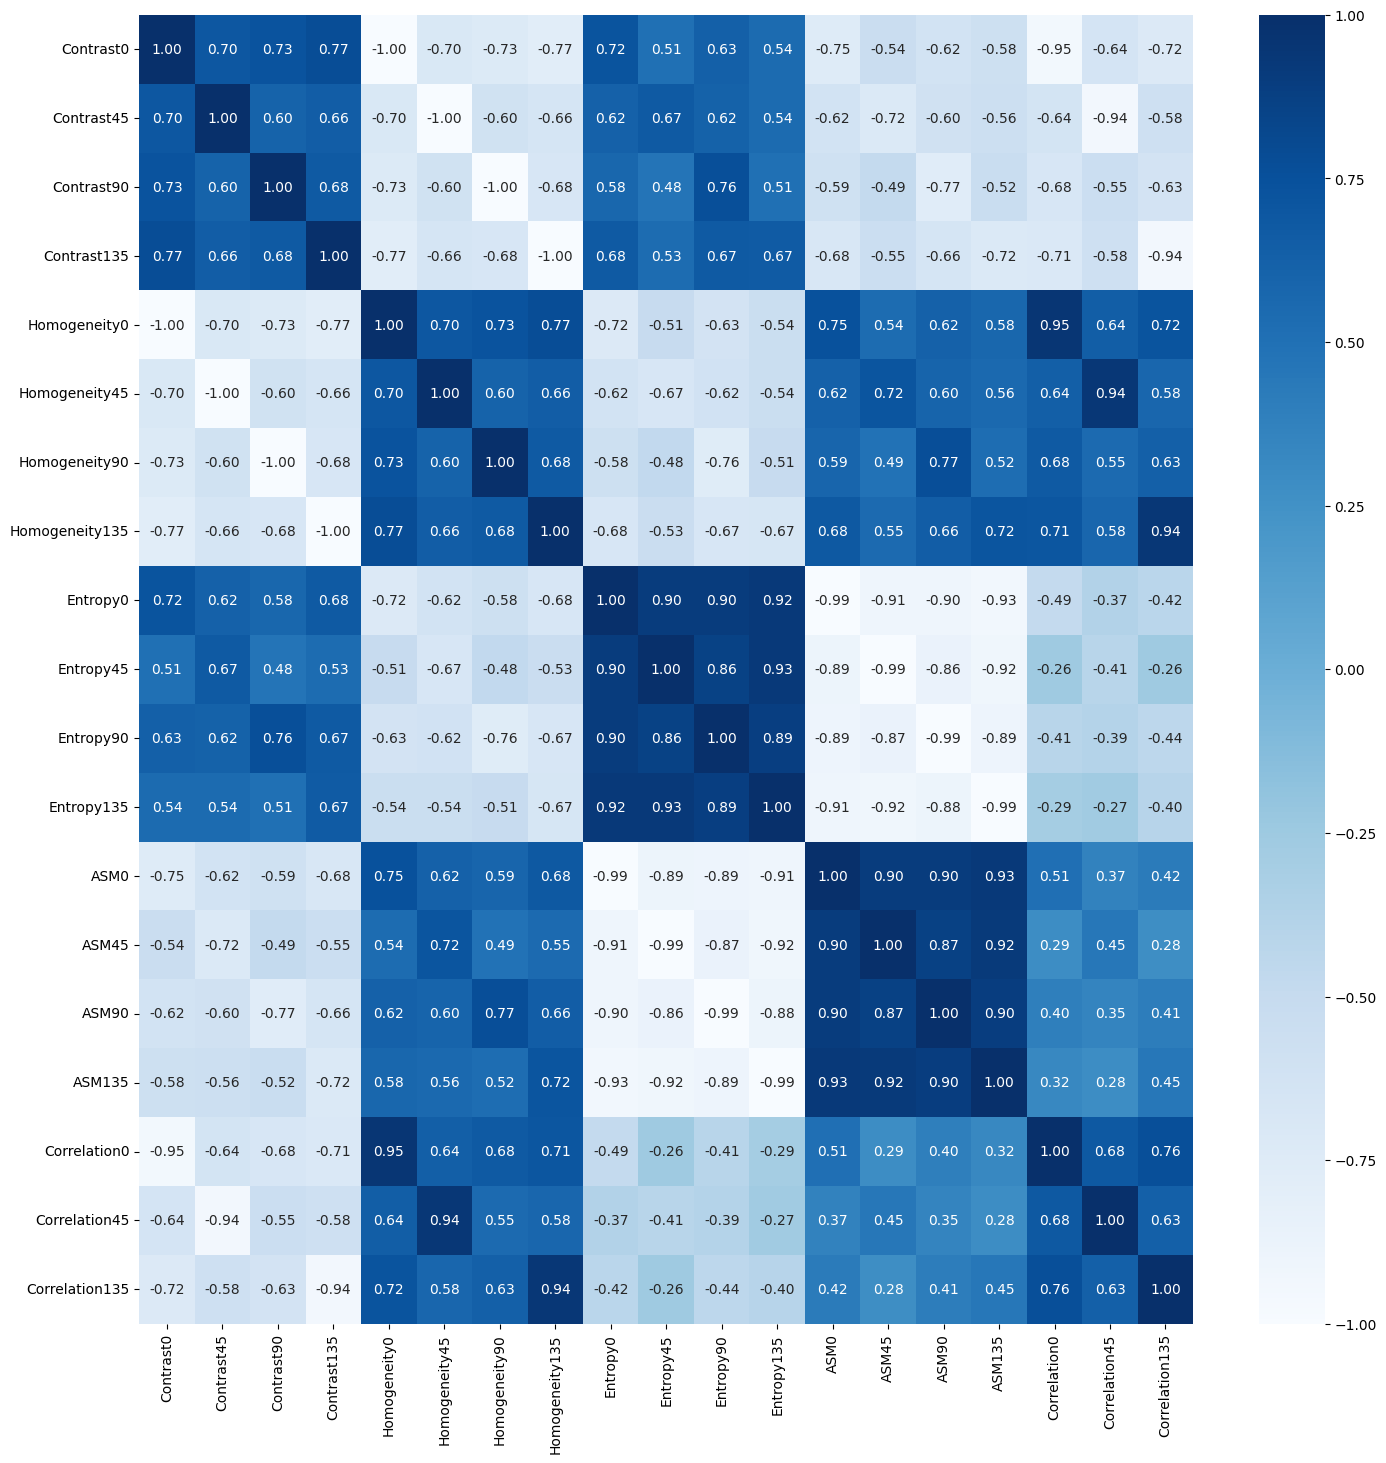

In [31]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [32]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(263, 19)
(66, 19)


Kode ini membagi dataset fitur x dan label y menjadi dua bagian: data pelatihan (training) dan data pengujian (testing) menggunakan fungsi train_test_split dari sklearn.model_selection. Parameter test_size=0.3 berarti 30% data digunakan untuk testing, dan sisanya 70% untuk training. random_state=42 digunakan agar pembagian data selalu konsisten ketika kode dijalankan ulang. Setelah pembagian, ukuran dataset training dan testing untuk fitur (x_train, x_test) serta label (y_train, y_test) dicetak ke layar agar dapat dilihat. Ini penting untuk persiapan model machine learning.

## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [33]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode ini mendefinisikan fungsi normalize_data untuk melakukan normalisasi data dengan metode standardization—yaitu mengubah data sehingga memiliki rata-rata (mean) 0 dan standar deviasi (std) 1 pada setiap fitur. Fungsi ini menghitung rata-rata dan standar deviasi kolom per kolom pada data, lalu mengurangi mean dan membagi dengan std untuk setiap elemen. Setelah fungsi didefinisikan, normalisasi diterapkan pada data training (x_train) dan data testing (x_test)

## Modeling

### Define Model

In [34]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode ini mendefinisikan fungsi generateClassificationReport yang menerima label asli (y_true) dan prediksi model (y_pred), kemudian mencetak tiga metrik evaluasi: laporan klasifikasi lengkap (classification_report) yang berisi precision, recall, f1-score per kelas; matriks kebingungan (confusion_matrix) yang menunjukkan distribusi prediksi benar/salah; dan akurasi keseluruhan (accuracy_score).

Selanjutnya, kode juga mendefinisikan tiga model klasifikasi yang akan digunakan:

    rf: Random Forest dengan 5 pohon keputusan (n_estimators=5) dan seed acak 42 untuk konsistensi hasil,

    svm: Support Vector Machine dengan kernel Radial Basis Function (RBF),

    knn: K-Nearest Neighbors dengan 5 tetangga terdekat.

Model-model ini nantinya bisa dilatih dan diuji pada data yang sudah disiapkan.

### Train Random Forest Classifier

In [35]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

      Kawung       0.94      0.93      0.93        85
      Parang       0.95      0.95      0.95        96
      Tumpal       0.93      0.94      0.93        82

    accuracy                           0.94       263
   macro avg       0.94      0.94      0.94       263
weighted avg       0.94      0.94      0.94       263

[[79  3  3]
 [ 2 91  3]
 [ 3  2 77]]
Accuracy: 0.9391634980988594

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.56      0.61      0.58        23
      Parang       0.52      0.71      0.60        21
      Tumpal       0.83      0.45      0.59        22

    accuracy                           0.59        66
   macro avg       0.64      0.59      0.59        66
weighted avg       0.64      0.59      0.59        66

[[14  7  2]
 [ 6 15  0]
 [ 5  7 10]]
Accuracy: 0.5909090909090909


Kode ini melatih model Random Forest (rf) menggunakan data training x_train dan y_train dengan memanggil fit(). Setelah itu, model digunakan untuk memprediksi kelas pada data training (x_train) dan hasil prediksi tersebut dibandingkan dengan label asli y_train untuk mengevaluasi performa model pada data pelatihan, dengan hasil evaluasi dicetak menggunakan fungsi generateClassificationReport.

Kemudian, model juga diuji pada data testing (x_test), dengan prediksi dibandingkan terhadap label asli y_test, untuk menilai performa model pada data yang belum pernah dilihat sebelumnya. Evaluasi testing ini juga ditampilkan dengan laporan klasifikasi, matriks kebingungan, dan akurasi agar dapat menilai kemampuan generalisasi model.

### Train SVM Classifier

In [36]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      Kawung       0.67      0.58      0.62        85
      Parang       0.77      0.68      0.72        96
      Tumpal       0.61      0.79      0.69        82

    accuracy                           0.68       263
   macro avg       0.69      0.68      0.68       263
weighted avg       0.69      0.68      0.68       263

[[49 12 24]
 [14 65 17]
 [10  7 65]]
Accuracy: 0.6806083650190115

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.85      0.74      0.79        23
      Parang       0.64      0.76      0.70        21
      Tumpal       0.76      0.73      0.74        22

    accuracy                           0.74        66
   macro avg       0.75      0.74      0.74        66
weighted avg       0.75      0.74      0.74        66

[[17  3  3]
 [ 3 16  2]
 [ 0  6 16]]
Accuracy: 0.7424242424242424


Kode di atas digunakan untuk melatih dan mengevaluasi model klasifikasi Support Vector Machine (SVM) dengan kernel Radial Basis Function (RBF). Pertama, model SVM dilatih menggunakan data pelatihan (x_train dan y_train) melalui metode .fit(). Setelah model dilatih, evaluasi dilakukan dalam dua tahap, yaitu terhadap data pelatihan dan data pengujian. Pada tahap evaluasi pertama, prediksi dilakukan terhadap data pelatihan menggunakan metode .predict() dan hasilnya dibandingkan dengan label sebenarnya untuk menilai apakah model mengalami overfitting, yaitu jika akurasi pada data pelatihan sangat tinggi namun rendah pada data pengujian. Selanjutnya, evaluasi dilakukan terhadap data pengujian untuk mengukur kemampuan generalisasi model terhadap data baru yang belum pernah dilihat sebelumnya. Hasil evaluasi ditampilkan dalam bentuk classification report yang mencakup precision, recall, dan F1-score untuk setiap kelas, serta confusion matrix yang menunjukkan jumlah prediksi benar dan salah, dan akurasi keseluruhan model. Evaluasi ini penting untuk mengetahui seberapa baik model SVM dalam mengklasifikasikan citra berdasarkan fitur yang telah diekstraksi sebelumnya.

### Train KNN Classifier

In [37]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

      Kawung       0.68      0.69      0.69        85
      Parang       0.79      0.74      0.76        96
      Tumpal       0.72      0.76      0.74        82

    accuracy                           0.73       263
   macro avg       0.73      0.73      0.73       263
weighted avg       0.73      0.73      0.73       263

[[59  9 17]
 [18 71  7]
 [10 10 62]]
Accuracy: 0.7300380228136882

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.70      0.70      0.70        23
      Parang       0.58      0.71      0.64        21
      Tumpal       0.76      0.59      0.67        22

    accuracy                           0.67        66
   macro avg       0.68      0.67      0.67        66
weighted avg       0.68      0.67      0.67        66

[[16  4  3]
 [ 5 15  1]
 [ 2  7 13]]
Accuracy: 0.6666666666666666


Kode di atas digunakan untuk melatih dan mengevaluasi model klasifikasi K-Nearest Neighbors (KNN). Model KNN dilatih dengan data pelatihan x_train dan label y_train menggunakan metode .fit(), meskipun secara teknis KNN tidak benar-benar melakukan pelatihan dalam arti tradisional—melainkan menyimpan data pelatihan untuk digunakan saat prediksi. Setelah itu, prediksi dilakukan terhadap data pelatihan dan data pengujian menggunakan metode .predict(). Evaluasi hasil prediksi dilakukan menggunakan fungsi generateClassificationReport, yang mencetak classification report (berisi precision, recall, dan F1-score), confusion matrix, dan nilai akurasi. Evaluasi terhadap data pelatihan menunjukkan seberapa baik KNN mengenali pola dari data yang sudah diketahui, sedangkan evaluasi terhadap data pengujian menunjukkan performa generalisasi model terhadap data baru. Parameter n_neighbors=5 menunjukkan bahwa prediksi ditentukan berdasarkan 5 tetangga terdekat dalam ruang fitur. Evaluasi ini berguna untuk menilai apakah jumlah tetangga sudah optimal dan apakah KNN merupakan pilihan model yang tepat untuk dataset citra yang telah diekstraksi fiturnya sebelumnya.

## Evaluation With Confusion Matrix

Kode tersebut berfungsi untuk memvisualisasikan matriks kebingungan (confusion matrix) dari tiga model klasifikasi: Random Forest, SVM, dan KNN, terhadap data pengujian. Fungsi plot_confusion_matrix menerima label sebenarnya (y_true), label hasil prediksi (y_pred), dan judul grafik (title). Di dalam fungsi, matriks kebingungan dihitung menggunakan confusion_matrix, lalu divisualisasikan dengan ConfusionMatrixDisplay dari sklearn.metrics, dan ditampilkan dengan matplotlib.pyplot.

Masing-masing pemanggilan fungsi plot_confusion_matrix menampilkan grafik matriks kebingungan untuk model yang berbeda dengan skema warna biru (cmap=plt.cm.Blues) agar lebih mudah dibaca. Visualisasi ini penting karena menunjukkan secara langsung berapa banyak prediksi yang benar dan salah untuk setiap kelas, serta memperlihatkan pola kesalahan klasifikasi—misalnya, jika ada dua kelas yang sering tertukar. Ini sangat membantu untuk memahami kelemahan model lebih dalam daripada hanya melihat nilai akurasi semata.

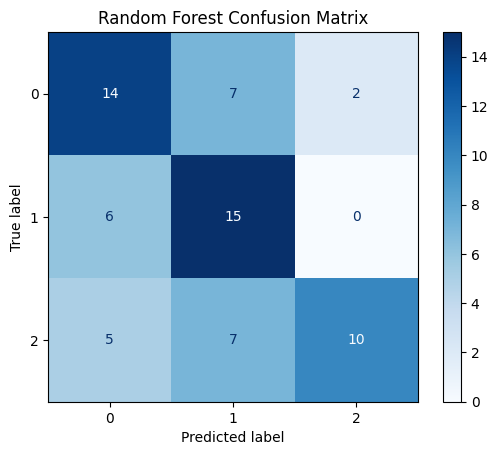

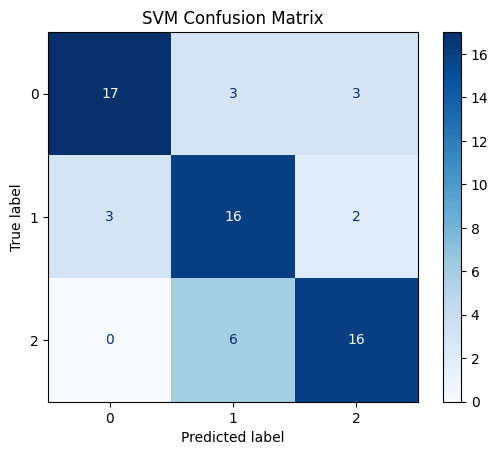

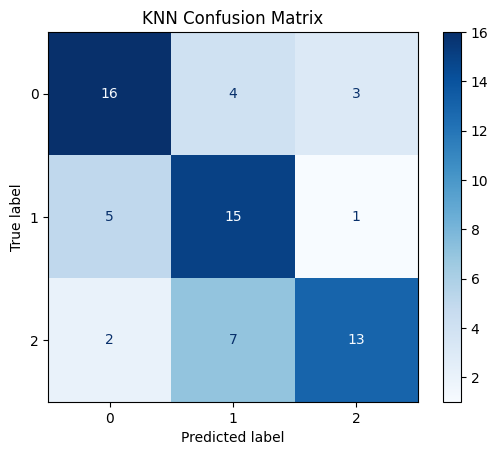

In [38]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

## Analisis Percobaan dan Hasil Augmentasi Data

Dalam penelitian ini, dilakukan empat percobaan prapemrosesan citra dengan metode yang berbeda, serta satu percobaan tambahan berupa augmentasi data. Berikut penjelasan tiap percobaan:

### Percobaan 1: Equalisasi dan Thresholding
Pada percobaan pertama, citra terlebih dahulu ditingkatkan kontrasnya menggunakan metode **equalisasi histogram**. Setelah itu, dilakukan proses **thresholding** untuk mengubah citra menjadi biner, agar memudahkan proses ekstraksi ciri.

### Percobaan 2: Equalisasi, Smoothing, dan Filter Median
Percobaan kedua masih menggunakan **equalisasi histogram**, kemudian dilanjutkan dengan **smoothing** (perataan nilai piksel) untuk mengurangi noise, dan diakhiri dengan **filter median** berukuran 3x3 untuk mengatasi noise tipe salt-and-pepper.

### Percobaan 3: Filter Median, Sharpening, Equalisasi, dan Normalisasi
Pada percobaan ketiga, urutan prapemrosesan dimulai dengan **filter median**, kemudian **sharpening** untuk menonjolkan tepi objek, dilanjutkan **equalisasi**, dan diakhiri dengan **normalisasi** untuk menyamakan skala nilai piksel.

### Percobaan 4: Augmentasi Data (Equalisasi + Thresholding)
Percobaan terakhir dilakukan augmentasi data menggunakan kombinasi **equalisasi dan thresholding**. Setiap citra diputar pada berbagai sudut rotasi, kemudian dilakukan flip horizontal dan vertikal. Jumlah data meningkat dari **329 citra menjadi 4.935 citra**.

---

## Hasil dan Analisis

Meskipun jumlah data meningkat secara signifikan pada percobaan keempat, hasil **akurasi model tidak menunjukkan peningkatan**. Nilai akurasi tetap sama seperti saat menggunakan data awal tanpa augmentasi.

### Kemungkinan Penyebab Tidak Ada Peningkatan Akurasi:

1. **Jenis Augmentasi Terlalu Sederhana**  
   Augmentasi hanya mencakup rotasi dan flip yang menghasilkan citra dengan pola yang sangat mirip, sehingga tidak menambah informasi baru yang cukup bermakna bagi model.

2. **Model Sudah Overfitting pada Data Awal**  
   Model mungkin sudah terlalu cocok dengan pola data awal, sehingga data tambahan dari augmentasi tidak memberikan pengaruh yang signifikan.

3. **Distribusi Kelas Tidak Diatur Ulang**  
   Augmentasi dilakukan secara merata tanpa mempertimbangkan distribusi label, sehingga ketidakseimbangan kelas tetap ada dan model tidak belajar dengan adil terhadap semua kelas.

4. **Pengaturan Training Tidak Dioptimalkan**  
   Setelah augmentasi, seharusnya parameter pelatihan seperti jumlah epoch, batch size, dan learning rate disesuaikan untuk mengakomodasi dataset yang lebih besar.

---

## Kesimpulan

Meningkatkan jumlah data dengan augmentasi **tidak selalu menjamin peningkatan akurasi**. Yang lebih penting adalah **kualitas dan keragaman** data hasil augmentasi, serta **pengaturan pelatihan yang sesuai**. Untuk ke depan, disarankan agar augmentasi menggunakan variasi yang lebih kompleks dan pengaturan pelatihan model dievaluasi ulang.
